In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install imblearn

In [2]:
import numpy as np
import pandas as pd

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [7]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [8]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [9]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [10]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

**Пути к директориям и файлам**

In [11]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [12]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [13]:
test_df = pd.read_csv(TEST_DATASET_PATH)

# ТЕКУЩИЕ ВОЗМОЖНОСТИ

In [14]:
TARGET_NAME = 'Credit Default'

In [15]:
def generate_dummies_from_home_ownership(X):
    X['G_home_ownership_home_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Home Mortgage', 'G_home_ownership_home_mortgage'] = 1
    
    X['G_home_ownership_rent'] = 0
    X.loc[X['Home Ownership'] == 'Rent', 'G_home_ownership_rent'] = 1
    
    X['G_home_ownership_own_home'] = 0
    X.loc[X['Home Ownership'] == 'Own Home', 'G_home_ownership_own_home'] = 1
    
    X['G_home_ownership_have_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Have Mortgage', 'G_home_ownership_have_mortgage'] = 1
    
    X['G_home_ownership_other'] = 0
    X.loc[~X['Home Ownership'].isin(['Home Mortgage', 'Rent', 'Own Home', 'Have Mortgage']), 'G_home_ownership_other'] = 1
    
    return X

In [16]:
def generate_G_home_ownership_reduced_to_binary(X):
    X['G_home_ownership_reduced_to_binary'] = 0
    X.loc[~X['Home Ownership'].isin(['Own Home', 'Rent']), 'G_home_ownership_reduced_to_binary'] = 1
    return X

In [17]:
def generate_G_years_in_current_job_reduced_to_binary(X):
    X['G_years_in_current_job_reduced_to_binary'] = 0
    X.loc[X['Years in current job'].isna(), 'G_years_in_current_job_reduced_to_binary'] = 1
    return X

In [18]:
def generate_G_purpose_reduced_to_binary(X):
    X['G_purpose_reduced_to_binary'] = 0
    X.loc[X['Purpose'].isin(['business loan', 'small business']), 'G_purpose_reduced_to_binary'] = 1
    return X

In [19]:
def generate_G_term_transformed_to_binary(X):
    X['G_term_transformed_to_binary'] = 0
    X.loc[X['Term'] == 'Long Term', 'G_term_transformed_to_binary'] = 1
    return X

In [20]:
def generate_G_tax_liens_reduced_to_binary(X):
    X['G_tax_liens_reduced_to_binary'] = 0
    X.loc[X['Tax Liens'].isin([2, 3, 4, 5]), 'G_tax_liens_reduced_to_binary'] = 1   
    return X

In [21]:
def generate_G_number_of_credit_problems_reduced_to_binary(X):
    X['G_number_of_credit_problems_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_number_of_credit_problems_reduced_to_binary'] = 1   
    return X

In [22]:
def generate_G_bankruptcies_reduced_to_binary(X):
    X['G_bankruptcies_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_bankruptcies_reduced_to_binary'] = 1  
    return X

In [23]:
def generate_G_annual_income_was_nan(X):
    X['G_annual_income_was_nan'] = 0
    X.loc[X['Annual Income'].isna(), 'G_annual_income_was_nan'] = 1  
    return X

In [24]:
def generate_target_encoded_feature_for_a_numerical_feature(df, number_of_categories, 
                                                            feature_name, target_name, 
                                                            push_right_min_outliers_in_feature_name, 
                                                            push_left_max_outliers_in_feature_name):
    # функция генерирует новый признак
    # путём разбиения пространства оригинального признака на заданное количество равных интервалов
    # и просчитывает пропорцию / вероятность  объектов с целевой переменной == 1
    # к общему числу объектов на каждом интервале
    # с присвоением значения вероятности какждому объекту в виде значения нового признака.
    # NB! если в оригинальном признаке есть пропуски, то для них будет создана отдельная,
    # дополнительная подкатегория внутри нового признака, вдобавок к заданному количеству в параметре number_of_categories.
    # при генерации нового признака используя действительную функцию
    # следует проверить целесообразность такого действия 
    # при помощи другой, написанной выше функции check_whether_categorization_with_target_encoding_is_valid
    # NB! функция может присваивать 2.5% минимальных и 2.5% максимальных значений (выбросы) в оригинальном признаке
    # значения равные 2.5% от минимума и 2.5% от максимума соответственно.
    
    X = df.copy()
    
    # присваивание 2.5% минимальных и 2.5% максимальных значений (выбросам) в оригинальном признаке
    # значений равных 2.5% от минимума и 2.5% от максимума соответственно
    value_q_0025 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.025)
    value_q_0975 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.975)
    
    if push_right_min_outliers_in_feature_name:
        X.loc[X[feature_name] < value_q_0025, feature_name] = value_q_0025
        
    if push_left_max_outliers_in_feature_name:
        X.loc[X[feature_name] > value_q_0975, feature_name] = value_q_0975
    
    # выявление минимального и максимального значений на пространстве значений исходного признака
    feature_min_value = X[feature_name].min()
    feature_max_value = X[feature_name].max()
    
    # создание интервалов из пространства значений исходного признака
    limits_of_categories = np.linspace(feature_min_value, feature_max_value, number_of_categories + 1)
    
    # генерация имени нового признака
    new_feature_name = 'G_' + f'{feature_name}'.lower().replace(' ', '_') + '_target_encoded'
    
    # заполнение нового признака средним значением целевой переменной -
    # перестраховка, чтобы избежать возможности пропусков
    X[new_feature_name] = X[target_name].mean()
    
    # заполнение пропусков в признаке средним значением целевой переменной на объектах,
    # где есть пропуски в признаках
    X.loc[df[feature_name].isna(), new_feature_name] = X.loc[df[feature_name].isna(), target_name].mean()
    
    # присвоение каждому объекту значения нового признака равного вероятности 
    # появления значения целевой переменной == 1 на заданном интервале оригинального признака
    i = 0
    while True:
        if i == number_of_categories:
            break

        try:
            category_stat =\
                X.loc[(df[feature_name] >= limits_of_categories[i]) & 
                      (df[feature_name] < limits_of_categories[i + 1])][target_name].value_counts()
            
            X.loc[(df[feature_name] >= limits_of_categories[i]) & 
                  (df[feature_name] < limits_of_categories[i + 1]), 
                  new_feature_name] = round((category_stat[1] / sum(category_stat)), 3) 
            
        except:
            None

        i += 1
        
    return X

In [25]:
df = train_df.copy()

In [26]:
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


In [27]:
df = generate_dummies_from_home_ownership(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,99999999.0,47386.0,7914.0,749.0,0,0,0,1,0,0


In [28]:
df = generate_G_home_ownership_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,47386.0,7914.0,749.0,0,0,0,1,0,0,0


In [29]:
df = generate_G_years_in_current_job_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,7914.0,749.0,0,0,0,1,0,0,0,1


In [30]:
df = generate_G_purpose_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,749.0,0,0,0,1,0,0,0,1,0


In [31]:
df = generate_G_term_transformed_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,0,1,0,0,0,1,0,0


In [32]:
df = generate_G_tax_liens_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,1,0,0,0,1,0,0,0


In [33]:
df = generate_G_number_of_credit_problems_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary,G_number_of_credit_problems_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,1,0,0,0,1,0,0,0,0


In [34]:
df = generate_G_bankruptcies_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary,G_number_of_credit_problems_reduced_to_binary,G_bankruptcies_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,1,0,0,0,1,0,0,0,0,0


In [35]:
df = generate_G_annual_income_was_nan(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary,G_number_of_credit_problems_reduced_to_binary,G_bankruptcies_reduced_to_binary,G_annual_income_was_nan
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,0,1,0,0,0,0,0,0


In [36]:
df.isna().sum()

Home Ownership                                      0
Annual Income                                    1557
Years in current job                              371
Tax Liens                                           0
Number of Open Accounts                             0
Years of Credit History                             0
Maximum Open Credit                                 0
Number of Credit Problems                           0
Months since last delinquent                     4081
Bankruptcies                                       14
Purpose                                             0
Term                                                0
Current Loan Amount                                 0
Current Credit Balance                              0
Monthly Debt                                        0
Credit Score                                     1557
Credit Default                                      0
G_home_ownership_home_mortgage                      0
G_home_ownership_rent       

In [37]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Annual Income',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=True)

In [38]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Current Loan Amount',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

In [39]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Maximum Open Credit',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=True)

In [40]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=5, 
                                                             feature_name='Number of Open Accounts',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=True)

In [41]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Years of Credit History',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

In [42]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Monthly Debt',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

In [43]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Months since last delinquent',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

In [44]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Credit Score',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=False)

#### заполнение количественных признаков медианами для базового решения

In [45]:
# df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())

df['Annual Income'] = df['Annual Income'].fillna(300000.1)

df['Months since last delinquent'] = df['Months since last delinquent'].fillna(df['Months since last delinquent'].median())

# df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].median())

df['Credit Score'] = df['Credit Score'].fillna(680.1)

In [46]:
print(df['Annual Income'].isna().sum())
print(df['Months since last delinquent'].isna().sum())
print(df['Credit Score'].isna().sum())

0
0
0


#### заполнение категориальных признаков модами для базового решения

In [47]:
df['Years in current job'] = df['Years in current job'].fillna(df['Years in current job'].mode()[0])
df['Bankruptcies'] = df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0])

In [48]:
print(df['Years in current job'].isna().sum())
print(df['Bankruptcies'].isna().sum())

0
0


#### проверка на отсутствие пропусков в датафрейме для базового решения

In [49]:
df.isna().sum().sum()

0

In [50]:
df.dtypes

Home Ownership                                    object
Annual Income                                    float64
Years in current job                              object
Tax Liens                                        float64
Number of Open Accounts                          float64
Years of Credit History                          float64
Maximum Open Credit                              float64
Number of Credit Problems                        float64
Months since last delinquent                     float64
Bankruptcies                                     float64
Purpose                                           object
Term                                              object
Current Loan Amount                              float64
Current Credit Balance                           float64
Monthly Debt                                     float64
Credit Score                                     float64
Credit Default                                     int64
G_home_ownership_home_mortgage 

#### Разбиение на train и test

In [51]:
TARGET_NAME = 'Credit Default'

X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
#                                                     random_state=21, 
                                                    random_state=29,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

# ПРИСВОИМ ОБЪЕКТАМ С Current Loan Amount' == 99999999.0 ЗНАЧЕНИЕ TARGET == 0, А ОБЪЕКТАМ С Credit Score > 1000 ЗНАЧЕНИЕ TARGET == 1

In [52]:
X_train.shape

(5250, 37)

In [53]:
X_test.shape

(2250, 37)

In [54]:
X_train[X_train['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

617

In [55]:
X_test[X_test['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

253

In [56]:
indexes_of_X_train_with_target_0 = X_train[X_train['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].index
indexes_of_X_test_with_target_0 = X_test[X_test['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].index

In [57]:
# X_train = X_train.drop(['Current Loan Amount'], axis=1)
# X_test = X_test.drop(['Current Loan Amount'], axis=1)

In [58]:
y_train[indexes_of_X_train_with_target_0].value_counts()

0    617
Name: Credit Default, dtype: int64

In [59]:
y_test[indexes_of_X_test_with_target_0].value_counts()

0    253
Name: Credit Default, dtype: int64

In [60]:
X_train[X_train['Credit Score'] > 1000]['Credit Score'].count()

281

In [61]:
X_test[X_test['Credit Score'] > 1000]['Credit Score'].count()

119

In [62]:
indexes_of_X_train_with_target_1 = X_train[X_train['Credit Score'] > 1000]['Credit Score'].index
indexes_of_X_test_with_target_1 = X_test[X_test['Credit Score'] > 1000]['Credit Score'].index

In [63]:
# X_train = X_train.drop(['Credit Score'], axis=1)
# X_test = X_test.drop(['Credit Score'], axis=1)

In [64]:
indexes_of_X_train_with_target_0_ = indexes_of_X_train_with_target_0.to_list()
indexes_of_X_train_with_target_1_ = indexes_of_X_train_with_target_1.to_list()

indexes_of_X_test_with_target_0_ = indexes_of_X_test_with_target_0.to_list()
indexes_of_X_test_with_target_1_ = indexes_of_X_test_with_target_1.to_list()


# train
X_train_reduced = X_train.drop(X_train[X_train.index.isin(indexes_of_X_train_with_target_0_+ 
                                                          indexes_of_X_train_with_target_1_)].index)

y_train_reduced = y_train.drop(y_train[y_train.index.isin(indexes_of_X_train_with_target_0_+ 
                                                          indexes_of_X_train_with_target_1_)].index)


# test
X_test_reduced = X_test.drop(X_test[X_test.index.isin(indexes_of_X_test_with_target_0_+ 
                                                      indexes_of_X_test_with_target_1_)].index)

y_test_reduced = y_test.drop(y_test[y_test.index.isin(indexes_of_X_test_with_target_0_+ 
                                                      indexes_of_X_test_with_target_1_)].index)

In [65]:
list_of_columns_to_drop = [
                            'Home Ownership', 
#                            'Annual Income', 
                           'Years in current job', 
                           'Tax Liens',
                           'Number of Open Accounts', 
                           'Years of Credit History',
                           'Maximum Open Credit', 
                           'Number of Credit Problems',
                           'Months since last delinquent', 
                           'Bankruptcies', 
                           'Purpose', 
                           'Term',
                           'Current Loan Amount', 
                           'Current Credit Balance', 
                           'Monthly Debt',
#                            'Credit Score', 
#                            'G_home_ownership_home_mortgage',
#                            'G_home_ownership_rent', 
#                            'G_home_ownership_own_home',
#                            'G_home_ownership_have_mortgage', 
#                            'G_home_ownership_other',
#                            'G_home_ownership_reduced_to_binary',
#                            'G_years_in_current_job_reduced_to_binary',
#                            'G_purpose_reduced_to_binary', 
#                            'G_term_transformed_to_binary',
#                            'G_tax_liens_reduced_to_binary',
#                            'G_number_of_credit_problems_reduced_to_binary',
#                            'G_bankruptcies_reduced_to_binary', 
                           'G_annual_income_was_nan',
#                            'G_annual_income_target_encoded',
#                            'G_current_loan_amount_target_encoded',
#                            'G_maximum_open_credit_target_encoded',
#                            'G_number_of_open_accounts_target_encoded',
#                            'G_years_of_credit_history_target_encoded',
#                            'G_monthly_debt_target_encoded',
#                            'G_months_since_last_delinquent_target_encoded',
#                            'G_credit_score_target_encoded'
                          ]

In [66]:
X_train_reduced = X_train_reduced.drop(list_of_columns_to_drop, axis=1)
X_test_reduced = X_test_reduced.drop(list_of_columns_to_drop, axis=1)

In [67]:
CAT_FEATURE_NAMES =['Home Ownership', 
                           'Years in current job', 
                           'Tax Liens',
                           'Years of Credit History',
                           'Number of Credit Problems',
                           'Bankruptcies', 
                           'Purpose', 
                           'Term',
                           ]

In [68]:
# CAT_FEATURE_NAMES =['G_home_ownership_home_mortgage', 
#                     'G_home_ownership_reduced_to_binary', 
#                     'G_years_in_current_job_reduced_to_binary', 
#                     'G_purpose_reduced_to_binary', 
#                     'G_term_transformed_to_binary', 
#                     'G_tax_liens_reduced_to_binary', 
#                     'G_number_of_credit_problems_reduced_to_binary', 
#                     'G_bankruptcies_reduced_to_binary', 
#                     'Home Ownership']

In [69]:
# X_train_reduced['Number of Credit Problems'] = X_train_reduced['Number of Credit Problems'].astype(int)
# X_train_reduced['Bankruptcies'] = X_train_reduced['Bankruptcies'].astype(int)
# X_train_reduced['Years of Credit History'] = X_train_reduced['Years of Credit History'].astype(int)
# X_train_reduced['Tax Liens'] = X_train_reduced['Tax Liens'].astype(int)

# X_test_reduced['Number of Credit Problems'] = X_test_reduced['Number of Credit Problems'].astype(int)
# X_test_reduced['Bankruptcies'] = X_test_reduced['Bankruptcies'].astype(int)
# X_test_reduced['Years of Credit History'] = X_test_reduced['Years of Credit History'].astype(int)
# X_test_reduced['Tax Liens'] = X_test_reduced['Tax Liens'].astype(int)

In [70]:
X_train_reduced.dtypes

Annual Income                                    float64
Credit Score                                     float64
G_home_ownership_home_mortgage                     int64
G_home_ownership_rent                              int64
G_home_ownership_own_home                          int64
G_home_ownership_have_mortgage                     int64
G_home_ownership_other                             int64
G_home_ownership_reduced_to_binary                 int64
G_years_in_current_job_reduced_to_binary           int64
G_purpose_reduced_to_binary                        int64
G_term_transformed_to_binary                       int64
G_tax_liens_reduced_to_binary                      int64
G_number_of_credit_problems_reduced_to_binary      int64
G_bankruptcies_reduced_to_binary                   int64
G_annual_income_target_encoded                   float64
G_current_loan_amount_target_encoded             float64
G_maximum_open_credit_target_encoded             float64
G_number_of_open_accounts_targe

#### удаление объектов

In [71]:
# df = df.drop(['Home Ownership', 
#               'Years in current job', 
#               'Purpose', 
#               'Term'], axis=1)

# df = df.drop(['Annual Income', 
#               'Tax Liens', 
#               'Number of Open Accounts', 
#               'Years of Credit History', 
#               'Maximum Open Credit', 
#               'Number of Credit Problems', 
#               'Months since last delinquent',
#               'Bankruptcies'], axis=1)

# df = df.drop([
#                 'Current Credit Balance',
#               'Monthly Debt',
# #               'Credit Score'
# ], axis=1)

## model

#### LogisticRegression

In [72]:
# scaler = StandardScaler()

# X_train_reduced = scaler.fit_transform(X_train_reduced)
# X_test_reduced = scaler.transform(X_test_reduced)

# model = LogisticRegression(random_state=21, class_weight={0:1, 1:2.54})

#### DecisionTreeClassifier

In [73]:
model = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.54},
                                    max_depth=4)

#### XGBClassifier

In [74]:
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from xgboost import XGBClassifier

In [75]:
# %%time
# model = xgb.XGBClassifier(random_state=21, 
#                           n_estimators=20
#                           )

#### LightGBM

In [76]:
from lightgbm import LGBMClassifier

In [77]:
# %%time
# model = lgbm.LGBMClassifier(random_state=21, 
#                             class_weight={0:1, 1:2.54},
#                             n_estimators=5
#                            )

#### CatBoost

In [78]:
from catboost import CatBoostClassifier

In [79]:
disbalance = y_train_reduced.value_counts()[0] / y_train_reduced.value_counts()[1]
disbalance

2.632721202003339

In [80]:
%%time
model = catb.CatBoostClassifier(silent=True, 
#                                 cat_features=CAT_FEATURE_NAMES,
                                one_hot_max_size=20,
                                class_weights=[1, disbalance],
                                random_state=21)

Wall time: 0 ns


In [81]:
# model = catb.CatBoostClassifier(silent=True, random_state=21,
#                                      class_weights=[1, disbalance],
#                                      eval_metric='F1',
#                                      cat_features=CAT_FEATURE_NAMES,
#                                 one_hot_max_size=10,
#                                      early_stopping_rounds=20,
#                                      use_best_model=True,
#                                      custom_metric=['Precision', 'Recall']
#                                     )


In [82]:
model.fit(X_train_reduced, y_train_reduced)
# model.fit(X_train_reduced, y_train_reduced, plot=True, eval_set=(X_test_reduced, y_test_reduced))

y_train_pred_reduced = model.predict(X_train_reduced)
y_test_pred_reduced = model.predict(X_test_reduced)

In [83]:
y_train_pred = y_train.copy()
y_test_pred = y_test.copy()

In [84]:
np.array(y_test_pred)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [85]:
y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[indexes_of_X_train_with_target_0] = 0
y_train_pred.loc[indexes_of_X_train_with_target_1] = 1

y_test_pred.loc[y_test_reduced.index] = y_test_pred_reduced
y_test_pred.loc[indexes_of_X_test_with_target_0] = 0
y_test_pred.loc[indexes_of_X_test_with_target_1] = 1

y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

In [86]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      3771
           1       0.66      0.85      0.74      1479

    accuracy                           0.84      5250
   macro avg       0.80      0.84      0.81      5250
weighted avg       0.86      0.84      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1616
           1       0.48      0.58      0.52       634

    accuracy                           0.70      2250
   macro avg       0.65      0.66      0.65      2250
weighted avg       0.72      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1216  400
1                269  365


#### Ничего не делаем с данными

In [87]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train_reduced, 
                                                         X_test_reduced, 
                                                         y_train_reduced, 
                                                         y_test_reduced, 
                                                         method='not')
stata_not_balanced

[01:30:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9.32 s


,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name
0,0.841098,0.840394,0.000000,0.000000,0.420549,0.420197,lr
1,0.802831,0.849891,0.258555,0.443483,0.530693,0.646687,knn
2,0.731111,0.989940,0.312500,0.972673,0.521806,0.981307,tree
3,0.818030,0.928486,0.283837,0.763366,0.550934,0.845926,xgb
4,0.825574,0.889790,0.246459,0.576987,0.536016,0.733389,lgbm
5,0.835386,0.882387,0.241791,0.514723,0.538588,0.698555,cat


#### Oversampling

In [88]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3154
1    2396
Name: Credit Default, dtype: int64

In [89]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [90]:
%%time
stata_balanced_over, models_over = run_experiment(X_train_balanced, 
                                                  X_test_reduced, 
                                                  y_train_balanced, 
                                                  y_test_reduced, 
                                                  method='over')
stata_balanced_over

[01:30:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9.49 s


,f1_0_test_over,f1_0_train_over,f1_1_test_over,f1_1_train_over,f1_macro_test_over,f1_macro_train_over,model_name
0,0.841098,0.724724,0.000000,0.000000,0.420549,0.362362,lr
1,0.720361,0.779784,0.323931,0.678342,0.522146,0.729063,knn
2,0.736764,0.986201,0.342644,0.981856,0.539704,0.984029,tree
3,0.773888,0.909486,0.388560,0.874866,0.581224,0.892176,xgb
4,0.790167,0.845786,0.379347,0.765880,0.584757,0.805833,lgbm
5,0.796742,0.835204,0.384120,0.742144,0.590431,0.788674,cat


#### Undersampling

In [91]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

0    1198
1    1198
Name: Credit Default, dtype: int64

In [92]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [93]:
%%time
stata_balanced_under, models_under = run_experiment(X_train_balanced, 
                                                  X_test_reduced, 
                                                  y_train_balanced, 
                                                  y_test_reduced, 
                                                  method='under')
stata_balanced_under

[01:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 6.65 s


,f1_0_test_under,f1_0_train_under,f1_1_test_under,f1_1_train_under,f1_macro_test_under,f1_macro_train_under,model_name
0,0.602570,0.533630,0.401601,0.588928,0.502085,0.561279,lr
1,0.609756,0.717844,0.386301,0.705079,0.498029,0.711461,knn
2,0.597966,0.991304,0.391973,0.991165,0.494969,0.991235,tree
3,0.635100,0.935765,0.422283,0.934847,0.528692,0.935306,xgb
4,0.652868,0.882110,0.439805,0.879121,0.546336,0.880616,lgbm
5,0.680456,0.838446,0.454218,0.831700,0.567337,0.835073,cat


#### Undersampling (Tomeklinks)

In [94]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train_reduced, y_train_reduced)

y_train_balanced.value_counts()

0    2670
1    1198
Name: Credit Default, dtype: int64

In [95]:
%%time
stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, 
                                                    X_test_reduced, 
                                                    y_train_balanced, 
                                                    y_test_reduced, 
                                                    method='tomek')
stata_balanced_tomek

[01:31:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.26 s


,f1_0_test_tomek,f1_0_train_tomek,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,model_name
0,0.841098,0.816764,0.000000,0.000000,0.420549,0.408382,lr
1,0.768630,0.841498,0.304904,0.551485,0.536767,0.696491,knn
2,0.719265,0.988135,0.359825,0.972673,0.539545,0.980404,tree
3,0.798468,0.932403,0.344281,0.823694,0.571375,0.878049,xgb
4,0.820739,0.886747,0.342857,0.658359,0.581798,0.772553,lgbm
5,0.829723,0.869814,0.323179,0.565339,0.576451,0.717576,cat


#### Oversampling (SMOTE)

In [96]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train_reduced)

y_train_balanced.value_counts()

0    3154
1    3154
Name: Credit Default, dtype: int64

In [97]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, 
                                                    X_test_reduced, 
                                                    y_train_balanced, 
                                                    y_test_reduced, 
                                                    method='smote')
stata_balanced_smote

[01:31:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 6.13 s


,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote,model_name
0,0.606623,0.531637,0.402414,0.589198,0.504519,0.560418,lr
1,0.658123,0.746781,0.381451,0.766087,0.519787,0.756434,knn
2,0.725898,0.989474,0.347435,0.989282,0.536666,0.989378,tree
3,0.810356,0.925037,0.278772,0.915910,0.544564,0.920474,xgb
4,0.830076,0.883904,0.303935,0.861415,0.567006,0.872660,lgbm
5,0.826974,0.883192,0.265363,0.857042,0.546168,0.870117,cat


#### Сводим результаты вместе

In [98]:
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name')
stata_combined.head()

,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name,f1_0_test_under,f1_0_train_under,f1_1_test_under,...,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote
0,0.841098,0.840394,0.000000,0.000000,0.420549,0.420197,lr,0.602570,0.533630,0.401601,...,0.000000,0.000000,0.420549,0.408382,0.606623,0.531637,0.402414,0.589198,0.504519,0.560418
1,0.802831,0.849891,0.258555,0.443483,0.530693,0.646687,knn,0.609756,0.717844,0.386301,...,0.304904,0.551485,0.536767,0.696491,0.658123,0.746781,0.381451,0.766087,0.519787,0.756434
2,0.731111,0.989940,0.312500,0.972673,0.521806,0.981307,tree,0.597966,0.991304,0.391973,...,0.359825,0.972673,0.539545,0.980404,0.725898,0.989474,0.347435,0.989282,0.536666,0.989378
3,0.818030,0.928486,0.283837,0.763366,0.550934,0.845926,xgb,0.635100,0.935765,0.422283,...,0.344281,0.823694,0.571375,0.878049,0.810356,0.925037,0.278772,0.915910,0.544564,0.920474
4,0.825574,0.889790,0.246459,0.576987,0.536016,0.733389,lgbm,0.652868,0.882110,0.439805,...,0.342857,0.658359,0.581798,0.772553,0.830076,0.883904,0.303935,0.861415,0.567006,0.872660


In [99]:
stata_combined.describe()[
    ['f1_macro_test_not', 'f1_macro_test_under', 'f1_macro_test_over',
     'f1_macro_test_tomek', 'f1_macro_test_smote',
     'f1_1_test_not', 'f1_1_test_under', 'f1_1_test_over',
     'f1_1_test_tomek', 'f1_1_test_smote']
]

,f1_macro_test_not,f1_macro_test_under,f1_macro_test_over,f1_macro_test_tomek,f1_macro_test_smote,f1_1_test_not,f1_1_test_under,f1_1_test_over,f1_1_test_tomek,f1_1_test_smote
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.516431,0.522908,0.539802,0.537748,0.536452,0.223857,0.416030,0.303100,0.279174,0.329895
std,0.047939,0.029629,0.064549,0.060513,0.021869,0.112786,0.027325,0.150697,0.138084,0.055994
min,0.420549,0.494969,0.420549,0.420549,0.504519,0.000000,0.386301,0.000000,0.000000,0.265363
25%,0.524027,0.499043,0.526536,0.537462,0.524007,0.242958,0.394380,0.328609,0.309473,0.285063
50%,0.533355,0.515389,0.560464,0.555460,0.540615,0.252507,0.411942,0.360996,0.333018,0.325685
75%,0.537945,0.541925,0.583874,0.575182,0.545767,0.277517,0.435425,0.382927,0.343925,0.372947
max,0.550934,0.567337,0.590431,0.581798,0.567006,0.312500,0.454218,0.388560,0.359825,0.402414


In [100]:
stata_combined.sort_values('f1_1_test_over', ascending=False).iloc[0]

f1_0_test_not            0.81803
f1_0_train_not          0.928486
f1_1_test_not           0.283837
f1_1_train_not          0.763366
f1_macro_test_not       0.550934
f1_macro_train_not      0.845926
model_name                   xgb
f1_0_test_under           0.6351
f1_0_train_under        0.935765
f1_1_test_under         0.422283
f1_1_train_under        0.934847
f1_macro_test_under     0.528692
f1_macro_train_under    0.935306
f1_0_test_over          0.773888
f1_0_train_over         0.909486
f1_1_test_over           0.38856
f1_1_train_over         0.874866
f1_macro_test_over      0.581224
f1_macro_train_over     0.892176
f1_0_test_tomek         0.798468
f1_0_train_tomek        0.932403
f1_1_test_tomek         0.344281
f1_1_train_tomek        0.823694
f1_macro_test_tomek     0.571375
f1_macro_train_tomek    0.878049
f1_0_test_smote         0.810356
f1_0_train_smote        0.925037
f1_1_test_smote         0.278772
f1_1_train_smote         0.91591
f1_macro_test_smote     0.544564
f1_macro_t

In [101]:
model = models_over['lgbm']

In [102]:
# pred_train = model.predict(X_train_balanced)
# pred_test = model.predict(X_test_reduced)

# evaluate_preds(model, X_train_balanced, X_test_reduced, y_train_balanced, y_test_reduced)

In [103]:
# model.fit(X_train_reduced, y_train_reduced)
# model.fit(X_train_reduced, y_train_reduced, plot=True, eval_set=(X_test_reduced, y_test_reduced))

y_train_pred_reduced = model.predict(X_train_reduced)
y_test_pred_reduced = model.predict(X_test_reduced)

In [104]:
y_train_pred = y_train.copy()
y_test_pred = y_test.copy()

In [105]:
np.array(y_test_pred)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [106]:
y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[indexes_of_X_train_with_target_0] = 0
y_train_pred.loc[indexes_of_X_train_with_target_1] = 1

y_test_pred.loc[y_test_reduced.index] = y_test_pred_reduced
y_test_pred.loc[indexes_of_X_test_with_target_0] = 0
y_test_pred.loc[indexes_of_X_test_with_target_1] = 1

y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

In [107]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3771
           1       0.78      0.76      0.77      1479

    accuracy                           0.87      5250
   macro avg       0.84      0.84      0.84      5250
weighted avg       0.87      0.87      0.87      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1616
           1       0.54      0.47      0.50       634

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1362  254
1                335  299


# Выбор порога вероятности для определения класса

In [108]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()


In [109]:
y_test_reduced_pred_probs = model.predict_proba(X_test_reduced)
y_test_reduced_pred_probs

array([[0.34593624, 0.65406376],
       [0.79821734, 0.20178266],
       [0.92126285, 0.07873715],
       ...,
       [0.68554555, 0.31445445],
       [0.93424676, 0.06575324],
       [0.3505575 , 0.6494425 ]])

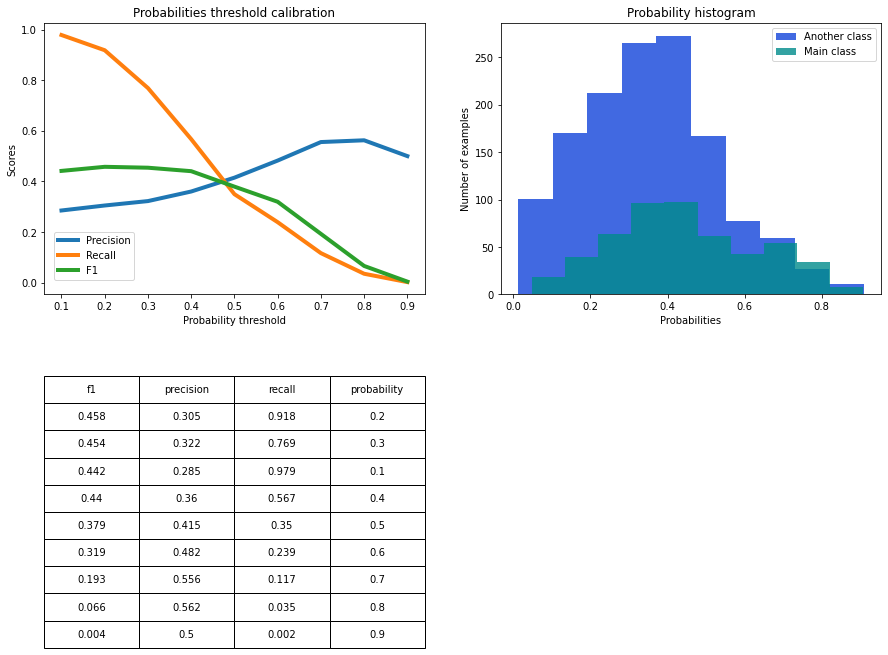

In [110]:
show_proba_calibration_plots(y_test_reduced_pred_probs[:, 1], y_test_reduced)

# -------------------------

In [111]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3154
1    2396
Name: Credit Default, dtype: int64

In [112]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [113]:
X_train_balanced.dtypes

Annual Income                                    float64
Credit Score                                     float64
G_home_ownership_home_mortgage                     int64
G_home_ownership_rent                              int64
G_home_ownership_own_home                          int64
G_home_ownership_have_mortgage                     int64
G_home_ownership_other                             int64
G_home_ownership_reduced_to_binary                 int64
G_years_in_current_job_reduced_to_binary           int64
G_purpose_reduced_to_binary                        int64
G_term_transformed_to_binary                       int64
G_tax_liens_reduced_to_binary                      int64
G_number_of_credit_problems_reduced_to_binary      int64
G_bankruptcies_reduced_to_binary                   int64
G_annual_income_target_encoded                   float64
G_current_loan_amount_target_encoded             float64
G_maximum_open_credit_target_encoded             float64
G_number_of_open_accounts_targe

In [114]:
from catboost import CatBoostClassifier

In [115]:
disbalance = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance

1.3163606010016695

In [116]:
# model = xgb.XGBClassifier(random_state=21, 
#                           n_estimators=20
#                           )

# model.fit(X_train_balanced, y_train_balanced)

# y_train_pred_reduced = model.predict_proba(X_train_reduced)
# y_test_pred_reduced = model.predict_proba(X_test_reduced)

In [117]:
# model = lgbm.LGBMClassifier(random_state=21, 
# #                             class_weight={0:1, 1:2.54},
#                             n_estimators=5
#                            )

# model.fit(X_train_balanced, y_train_balanced)

# y_train_pred_reduced = model.predict_proba(X_train_reduced)
# y_test_pred_reduced = model.predict_proba(X_test_reduced)

In [118]:
scaler = StandardScaler()

X_train_balanced_norm = X_train_balanced.copy()
X_train_reduced_norm = X_train_reduced.copy()
X_test_reduced_norm = X_test_reduced.copy()

X_train_balanced_norm = scaler.fit_transform(X_train_balanced_norm)
X_train_reduced_norm = scaler.transform(X_train_reduced_norm)
X_test_reduced_norm = scaler.transform(X_test_reduced_norm)

model = LogisticRegression(random_state=21,
                           class_weight={0:1, 1:disbalance})
model.fit(X_train_balanced_norm, y_train_balanced)

y_train_pred_reduced = model.predict_proba(X_train_reduced_norm)
y_test_pred_reduced = model.predict_proba(X_test_reduced_norm)

In [119]:
# model = DecisionTreeClassifier(random_state=21,
# #                                     class_weight={0:1, 1:2.55},
#                                     max_depth=3
#                                     )

# model.fit(X_train_balanced, y_train_balanced)

# y_train_pred_reduced = model.predict_proba(X_train_reduced)
# y_test_pred_reduced = model.predict_proba(X_test_reduced)

In [120]:
# X_train_balanced.dtypes

In [121]:
# model = catb.CatBoostClassifier(silent=True, 
#                                 random_state=21,
#                                 class_weights=[1, disbalance],
#                                 eval_metric='F1',
# #                                 cat_features=CAT_FEATURE_NAMES,
# #                                 one_hot_max_size=10,
#                                 early_stopping_rounds=100,
#                                 use_best_model=True,
#                                 custom_metric=['Precision', 'Recall']
#                                 )

# model.fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_test_reduced, y_test_reduced))

# y_train_pred_reduced = model.predict_proba(X_train_reduced)
# y_test_pred_reduced = model.predict_proba(X_test_reduced)

In [122]:
# y_train_pred_reduced = model.predict(X_train_reduced)
# y_test_pred_reduced = model.predict(X_test_reduced)

In [123]:
def classify_results_by_probability(array_of_results_in_probability, probability_threshold):
    list_of_results_in_1_and_0 = []
    for i in array_of_results_in_probability:
        if i[1] <= probability_threshold:
            list_of_results_in_1_and_0.append(0)
        elif i[1] > probability_threshold:
            list_of_results_in_1_and_0.append(1)
    return list_of_results_in_1_and_0    

In [124]:
probability_threshold = 0.564

y_train_pred_reduced = classify_results_by_probability(array_of_results_in_probability=y_train_pred_reduced,
                                                       probability_threshold=probability_threshold)

y_test_pred_reduced = classify_results_by_probability(array_of_results_in_probability=y_test_pred_reduced,
                                                      probability_threshold=probability_threshold)

#### classification_report до присоединения однозначно классифицированных объектов

In [125]:
get_classification_report(y_train_reduced, np.array(y_train_pred_reduced), y_test_reduced, np.array(y_test_pred_reduced))

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3154
           1       0.43      0.43      0.43      1198

    accuracy                           0.69      4352
   macro avg       0.61      0.61      0.61      4352
weighted avg       0.69      0.69      0.69      4352

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1363
           1       0.44      0.42      0.43       515

    accuracy                           0.69      1878
   macro avg       0.61      0.61      0.61      1878
weighted avg       0.69      0.69      0.69      1878

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1084  279
1                299  216


#### присоединение однозначно классифицированных объектов и финальный classification_report

In [126]:
y_train_pred = y_train.copy()
y_test_pred = y_test.copy()

In [127]:
y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[indexes_of_X_train_with_target_0] = 0
y_train_pred.loc[indexes_of_X_train_with_target_1] = 1

y_test_pred.loc[y_test_reduced.index] = y_test_pred_reduced
y_test_pred.loc[indexes_of_X_test_with_target_0] = 0
y_test_pred.loc[indexes_of_X_test_with_target_1] = 1

y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

In [128]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3771
           1       0.54      0.54      0.54      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.68      0.68      5250
weighted avg       0.74      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1616
           1       0.55      0.53      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1337  279
1                299  335
